In [1]:
import os, sys
sys.path.append('/root/catkin_ws/src/primitives/')
import pickle
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import axes3d
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import trimesh
import networkx

from open3d import JVisualizer

import copy
import time
import argparse
import numpy as np
from multiprocessing import Process, Pipe, Queue
import pickle
import rospy
import copy
import signal
import open3d
from IPython import embed

from yacs.config import CfgNode as CN
from closed_loop_experiments import get_cfg_defaults

from airobot import Robot
from airobot.utils import pb_util
from airobot.sensor.camera.rgbdcam_pybullet import RGBDCameraPybullet
from airobot.utils import common
import pybullet as p

from helper import util
from macro_actions import ClosedLoopMacroActions, YumiGelslimPybulet
# from closed_loop_eval import SingleArmPrimitives, DualArmPrimitives

In [2]:
sys.path.append('/root/training/')

import os
import argparse
import time
import numpy as np
import torch
from torch import nn
from torch import optim
from torch.autograd import Variable
from data_loader import DataLoader
from model import VAE
from util import to_var, save_state, load_net_state, load_seed, load_opt_state

In [63]:
# with open ('/root/catkin_ws/src/primitives/data/grasp/face_ind_test_0/2.pkl', 'rb') as f:
#     grasp_data = pickle.load(f)
    
# print(grasp_data.keys())

In [914]:
# with open ('/root/catkin_ws/src/primitives/data/pull/face_ind_large_0_fixed/1003.pkl', 'rb') as f:
#     pull_data = pickle.load(f)
got_file = False
while not got_file:
    val = np.random.randint(low=0, high=2000)
#     test_path = '/root/catkin_ws/src/primitives/data/pull/face_ind_large_0_fixed/%d.pkl' % val
    test_path = '/root/catkin_ws/src/primitives/data/grasp/face_ind_test_0_fixed/%d.pkl' % val
    if os.path.exists(test_path):
        with open (test_path, 'rb') as f:
#             pull_data = pickle.load(f)
            grasp_data = pickle.load(f)
            got_file = True

print(test_path)
# print(pull_data.keys())
print(grasp_data.keys())

/root/catkin_ws/src/primitives/data/grasp/face_ind_test_0_fixed/623.pkl
['goal', 'contact_obj_frame', 'contact_world_frame', 'transformation', 'start', 'result', 'keypoints_start', 'contact_pcd', 'keypoints_goal', 'obs', 'goal_face']


# Training data: 
## Inputs: 
Initial observation, different representations:
- ```'start'```: pose ```[x_pos, y_pos, z_pos, x_ori, y_ori, z_ori, w_ori]```
- ```'keypoints_start'```: 3D location of box corners at start pose
- ```'obs':'pcd_pts'```: Point cloud of box from 3 different viewpoints, with same global coordinate sys. Can be fused with np.concatenate (see below)

Goal, different representations:
- ```'goal'```: pose
- ```'keypoints_goal'```: 3D location of box corners at goal pose

In [915]:
# # start observation
# start = pull_data['start']
# keypoints_start = pull_data['keypoints_start']
# pcd_pts = pull_data['obs']['pcd_pts']
# pcd_pts_start = np.concatenate(pcd_pts, axis=0)

# # goal
# goal = pull_data['goal']
# keypoints_goal = pull_data['keypoints_goal']

# start observation
start = grasp_data['start']
keypoints_start = grasp_data['keypoints_start']
pcd_pts = grasp_data['obs']['pcd_pts']
pcd_pts_start = np.concatenate(pcd_pts, axis=0)

# goal
goal = grasp_data['goal']
keypoints_goal = grasp_data['keypoints_goal']

# Outputs:
## Pulling/Pushing (single arm)
Robot palm pose in the object frame, for active arm -- active arm currently based on which side of the table the object starts on. TODO perhaps includes predicting which arm is active, once we move to more diverse data. For now, everything for pulling happens with the right arm
- ```'contact_obj_frame'```: pose ```[x_pos, y_pos, z_pos, x_ori, y_ori, z_ori, w_ori]```, specified with respect to the coordinate system located at the object center of mass at the start pose

## Grasping/Pivoting (dual arm)

Right and left robot palm pose in the object frame
- ```'contact_obj_frame':'right'```: right palm pose ```[x_pos, y_pos, z_pos, x_ori, y_ori, z_ori, w_ori]```, specified with respect to the coordinate system located at the object center of mass at the start pose
- ```'contact_obj_frame':'left'```: left palm pose ```[x_pos, y_pos, z_pos, x_ori, y_ori, z_ori, w_ori]```, specified with respect to the coordinate system located at the object center of mass at the start pose

In [916]:
# right palm contact for pulling
# contact_r = pull_data['contact_obj_frame']

# both palms contact for grasping
contact_r = grasp_data['contact_obj_frame']['right']
contact_l = grasp_data['contact_obj_frame']['left']

# Training

In [917]:
## helpers

# load minibatch
# def load_minibatch(M, datatype='pose')


## setup

In [918]:
# load model architecture (encoder and decoder)
# setup optimizer

# setup loss function

## train loop

# for epoch in num_epochs:
# for minibatch in minibatch_size / data_size:
# forward pass, compute loss, backprop, optimizer.step
# look at loss

In [919]:
def pose_to_list(palm_pose_tensor):
    pos = palm_pose_tensor[:3].data.cpu().numpy()
    ori = palm_pose_tensor[3:].data.cpu().numpy()
    
    ori = ori/np.linalg.norm(ori)
    
    return pos.tolist() + ori.tolist()

# Testing

In [920]:
## setup

# distribution to sample from for start/goal (same as in training)

# load trained model

# vae = VAE(14, 7, 2, 0.0003)
# load_net_state(vae, '/root/training/saved_models/pose_init_small_batch_1/pose_init_small_batch_1_epoch_63.pt')

# vae = VAE(31, 7, 3, 0.0003)
# load_net_state(vae, '/root/training/saved_models/pull_keypoints_init_small_batch_0/pull_keypoints_init_small_batch_0_epoch_99.pt')

# vae = VAE(14, 14, 3, 0.0003)
# load_net_state(vae, '/root/training/saved_models/grasp_pose_init_small_batch_0/grasp_pose_init_small_batch_0_epoch_298.pt')

# vae = VAE(31, 14, 3, 0.0003)
# load_net_state(vae, '/root/training/saved_models/grasp_keypoints_init_small_batch_1/grasp_keypoints_init_small_batch_1_epoch_199.pt')

# vae = VAE(31, 7, 3, 0.0003)
# print(vae.encoder)
# print(vae.decoder)
# load_net_state(vae, '/root/training/saved_models/grasp_keypoints_two_heads_small_batch_r_only_0/grasp_keypoints_two_heads_small_batch_r_only_0_epoch_5.pt')

vae = VAE(31+14, 7, 2, 0.0003)
print(vae.encoder)
print(vae.decoder)
load_net_state(vae, '/root/training/saved_models/grasp_keypoints_two_heads_full_data_grasp_input_0/grasp_keypoints_two_heads_full_data_grasp_input_0_epoch_65.pt')


## eval

Encoder(
  (hidden_layers): Sequential(
    (0): Linear(in_features=45, out_features=128, bias=True)
    (1): ReLU()
  )
  (mu_head): Sequential(
    (0): Linear(in_features=128, out_features=2, bias=True)
  )
  (logvar_head): Sequential(
    (0): Linear(in_features=128, out_features=2, bias=True)
  )
)
Decoder(
  (decoder): Sequential(
    (0): Linear(in_features=33, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
  )
  (right_head): Sequential(
    (0): Linear(in_features=128, out_features=7, bias=True)
  )
  (left_head): Sequential(
    (0): Linear(in_features=128, out_features=7, bias=True)
  )
)


In [921]:
# sample from the latent space and use the decoder/generator to produce contacts, visualize below
# x = torch.from_numpy(np.asarray(start+goal, dtype=np.float32))
# x = torch.from_numpy(np.hstack((keypoints_start.flatten().astype(np.float32), np.asarray(goal, dtype=np.float32))))

x = torch.from_numpy(np.hstack((keypoints_start.flatten().astype(np.float32), np.asarray(goal, dtype=np.float32))))
contact_input = torch.from_numpy(np.asarray(contact_r+contact_l, dtype=np.float32))
decoder_input = x[:31]
z, pose_sample, z_mu, z_logvar = output = vae.forward(torch.cat((x, contact_input), dim=0), decoder_input)

In [922]:
print("mu: " + str(z_mu) + ", std: " + str(torch.exp(0.5*z_logvar)))

mu: tensor([0.0033, 0.0002], grad_fn=<AddBackward0>), std: tensor([0.9984, 1.0008], grad_fn=<ExpBackward>)


In [923]:
# pose = vae.decode(z)
# pose = vae.decode(z_mu)

z_sample = torch.randn_like(torch.zeros(2, ))

pose = vae.decode(z_sample, decoder_input)
print(pose)

(tensor([-0.0308,  0.0018,  0.0106,  0.0705, -0.0772,  0.0232,  0.0244],
       grad_fn=<AddBackward0>), tensor([ 0.0286, -0.0051,  0.0170,  0.0500,  0.0484, -0.0159,  0.0152],
       grad_fn=<AddBackward0>))


In [924]:
# pose_r = pose[:7]
# pose_l = pose[7:]

pose_r = pose[0]
pose_l = pose[1]

# pose = vae.decode(torch.normal(z_mu, torch.exp(0.5*z_logvar)))

In [925]:
# pos = pose[:3].data.cpu().numpy()
# ori = pose[3:].data.cpu().numpy()

pos = pose_r[:3].data.cpu().numpy()
ori = pose_r[3:].data.cpu().numpy()

In [926]:
ori = ori/np.linalg.norm(ori)

In [927]:
print(pos)
print(ori)

[-0.03083014  0.00180829  0.01064319]
[ 0.64170605 -0.70298547  0.21103881  0.22245751]


In [928]:
# pull_data_eval = copy.deepcopy(pull_data)
# pull_data_eval['contact_obj_frame'] = pos.tolist() + ori.tolist()

grasp_data_eval = copy.deepcopy(grasp_data)
grasp_data_eval['contact_obj_frame']['right'] = pose_to_list(pose_r)
grasp_data_eval['contact_obj_frame']['left'] = pose_to_list(pose_l)

In [929]:
# print("data: " + str(pull_data['contact_obj_frame']))
# print("--------")
# print("eval: " + str(pos.tolist() + ori.tolist()))

print("right: " + str(grasp_data_eval['contact_obj_frame']['right']))
print("----------------------------")
print("left: " + str(grasp_data_eval['contact_obj_frame']['left']))

right: [-0.030830135568976402, 0.0018082857131958008, 0.010643193498253822, 0.6417060494422913, -0.7029854655265808, 0.21103881299495697, 0.22245751321315765]
----------------------------
left: [0.02859966829419136, -0.005130734294652939, 0.01700582355260849, 0.6849772334098816, 0.6635352969169617, -0.2172907441854477, 0.2081148624420166]


# Visualization

In [829]:
# with open('/root/catkin_ws/src/primitives/data/pull/face_ind_large_0/metadata.pkl', 'rb') as mf:
#     metadata = pickle.load(mf)
with open('/root/catkin_ws/src/primitives/data/grasp/face_ind_test_0/metadata.pkl', 'rb') as mf:
    metadata = pickle.load(mf)


print('Metadata keys: ')
dynamics_info = metadata['dynamics']
mesh_file = metadata['mesh_file']
palm_mesh_file = '/root/catkin_ws/src/config/descriptions/meshes/mpalm/mpalms_all_coarse.stl'
table_mesh_file = '/root/catkin_ws/src/config/descriptions/meshes/table/table_top.stl'
cfg = metadata['cfg']

Metadata keys: 


# Visualize contact on object

In [906]:
def vis_palms(data, name='pull'):
    obj_mesh = trimesh.load_mesh(mesh_file)
    r_palm_mesh = trimesh.load_mesh(palm_mesh_file)
    l_palm_mesh = trimesh.load_mesh(palm_mesh_file)
    table_mesh = trimesh.load_mesh(table_mesh_file)
    
    obj_pos_world = data['start'][:3]
    obj_ori_world = data['start'][3:]
    obj_ori_mat = common.quat2rot(obj_ori_world)
    h_trans = np.zeros((4, 4))
    h_trans[:3, :3] = obj_ori_mat
    h_trans[:-1, -1] = obj_pos_world
    h_trans[-1, -1] = 1

    obj_mesh.apply_transform(h_trans)
    if name == 'pull':
        tip_contact_r_obj = util.list2pose_stamped(data['contact_obj_frame'])
        tip_contact_r = util.convert_reference_frame(
            pose_source=tip_contact_r_obj,
            pose_frame_target=util.unit_pose(),
            pose_frame_source=util.list2pose_stamped(data['start']))

        wrist_contact_r = util.convert_reference_frame(
            pose_source=util.list2pose_stamped(cfg.TIP_TO_WRIST_TF),
            pose_frame_target=util.unit_pose(),
            pose_frame_source=tip_contact_r)

        wrist_contact_r_list = util.pose_stamped2list(wrist_contact_r)
        
        palm_pos_world_r = wrist_contact_r_list[:3]
        palm_ori_world_r = wrist_contact_r_list[3:]
        palm_ori_mat = common.quat2rot(palm_ori_world_r)
        h_trans = np.zeros((4, 4))
        h_trans[:3, :3] = palm_ori_mat
        h_trans[:-1, -1] = palm_pos_world_r
        h_trans[-1, -1] = 1

        r_palm_mesh.apply_transform(h_trans)      
        
        scene = trimesh.Scene([obj_mesh, r_palm_mesh, table_mesh])        
    else:
        tip_contact_r_obj = util.list2pose_stamped(data['contact_obj_frame']['right'])
        tip_contact_l_obj = util.list2pose_stamped(data['contact_obj_frame']['left'])

        tip_contact_r = util.convert_reference_frame(
            pose_source=tip_contact_r_obj,
            pose_frame_target=util.unit_pose(),
            pose_frame_source=util.list2pose_stamped(data['start']))
            
        tip_contact_l = util.convert_reference_frame(
            pose_source=tip_contact_l_obj,
            pose_frame_target=util.unit_pose(),
            pose_frame_source=util.list2pose_stamped(data['start']))            
            
        wrist_contact_r = util.convert_reference_frame(
            pose_source=util.list2pose_stamped(cfg.TIP_TO_WRIST_TF),
            pose_frame_target=util.unit_pose(),
            pose_frame_source=tip_contact_r)

        wrist_contact_l = util.convert_reference_frame(
            pose_source=util.list2pose_stamped(cfg.TIP_TO_WRIST_TF),
            pose_frame_target=util.unit_pose(),
            pose_frame_source=tip_contact_l)

        wrist_contact_r_list = util.pose_stamped2list(wrist_contact_r)
        wrist_contact_l_list = util.pose_stamped2list(wrist_contact_l)
        
        palm_pos_world_r = wrist_contact_r_list[:3]
        palm_ori_world_r = wrist_contact_r_list[3:]
        palm_ori_mat = common.quat2rot(palm_ori_world_r)
        h_trans = np.zeros((4, 4))
        h_trans[:3, :3] = palm_ori_mat
        h_trans[:-1, -1] = palm_pos_world_r
        h_trans[-1, -1] = 1

        r_palm_mesh.apply_transform(h_trans)
        
        palm_pos_world_l = wrist_contact_l_list[:3]
        palm_ori_world_l = wrist_contact_l_list[3:]
        palm_ori_mat = common.quat2rot(palm_ori_world_l)
        h_trans = np.zeros((4, 4))
        h_trans[:3, :3] = palm_ori_mat
        h_trans[:-1, -1] = palm_pos_world_l
        h_trans[-1, -1] = 1

        l_palm_mesh.apply_transform(h_trans)        
        
        good_camera_euler = [1.0513555,  -0.02236318, -1.62958927]
        scene = trimesh.Scene([obj_mesh, r_palm_mesh, l_palm_mesh, table_mesh])
#         scene = trimesh.Scene([obj_mesh, r_palm_mesh, table_mesh])
        
        for key in scene.geometry.keys():
            print(key)
            if 'mpalms_all_coarse' in key:
                scene.geometry[key].visual.face_colors = [100, 100, 0, 30]

        scene.geometry['table_top.stl'].visual.face_colors = [200, 200, 200, 250]
        scene.geometry['realsense_box_experiments.stl'].visual.face_colors = [200, 200, 250, 250]
        scene.set_camera(angles=good_camera_euler, center=data['start'][:3], distance=0.8)
    return scene

In [907]:
def correct_pos(data):
    contact_obj_frame_pred = util.list2pose_stamped(pull_data_eval['contact_obj_frame'])
    contact_world_frame = util.convert_reference_frame(contact_obj_frame_pred, util.unit_pose(), util.list2pose_stamped(start))
    contact_pos = open3d.utility.DoubleVector(np.array(util.pose_stamped2list(contact_world_frame)[:3]))

    pcd = open3d.geometry.PointCloud()
    pcd.points = open3d.utility.Vector3dVector(np.concatenate(pull_data_eval['obs']['pcd_pts']))
    pcd.colors = open3d.utility.Vector3dVector(np.concatenate(pull_data_eval['obs']['pcd_colors']) / 255.0)

    kdtree = open3d.geometry.KDTreeFlann(pcd)
    nearest_pt_ind = kdtree.search_knn_vector_3d(contact_pos, 1)[1][0]
    nearest_pt_world = np.asarray(pcd.points)[nearest_pt_ind]

    contact_world_frame_corrected = copy.deepcopy(contact_world_frame)
    contact_world_frame_corrected.pose.position.x = nearest_pt_world[0]
    contact_world_frame_corrected.pose.position.y = nearest_pt_world[1]
    contact_world_frame_corrected.pose.position.z = nearest_pt_world[2]

    contact_obj_frame_corrected = util.pose_stamped2list(util.convert_reference_frame(contact_world_frame_corrected, util.list2pose_stamped(start), util.unit_pose()))
    new_data = copy.deepcopy(data)
    new_data['contact_obj_frame'] = contact_obj_frame_corrected
    return new_data

In [908]:
# scene = vis_palms(pull_data_eval, name='pull')
scene = vis_palms(grasp_data_eval, name='grasp')

scene.show(viewer='gl')

realsense_box_experiments.stl
mpalms_all_coarse.stl
mpalms_all_coarse.stl:B6NI8MS9H03A
table_top.stl


SceneViewer(width=1800, height=1350)

In [930]:
scene = vis_palms(grasp_data, name='grasp')

scene.show(viewer='gl')

realsense_box_experiments.stl
mpalms_all_coarse.stl
mpalms_all_coarse.stl:KKOCDEIASJUP
table_top.stl


SceneViewer(width=1800, height=1350)

In [934]:
scene = vis_palms(correct_pos(pull_data_eval), name='pull')
# scene = vis_palms(grasp_data, name='grasp')

scene.show(viewer='gl')

NameError: name 'pull_data_eval' is not defined

In [937]:
# x = torch.from_numpy(np.asarray(start+goal, dtype=np.float32))
# output = vae.forward(x)

# pos = output[1][:3].data.cpu().numpy()
# ori = output[1][3:].data.cpu().numpy()

# ori = ori/np.linalg.norm(ori)

# pull_data_eval = copy.deepcopy(pull_data)
# pull_data_eval['contact_obj_frame'] = pos.tolist() + ori.tolist()

# scene = vis_palms(pull_data_eval, name='pull')

# x = torch.from_numpy(np.hstack((keypoints_start.flatten().astype(np.float32), np.asarray(goal, dtype=np.float32))))
# output = vae.forward(x)

# pose_r = output[1][:7]
# pose_l = output[1][7:]

z_sample = torch.randn_like(torch.zeros(2, ))

pose = vae.decode(z_sample, decoder_input)
pose_r = pose[0]
pose_l = pose[1]

grasp_data_eval = copy.deepcopy(grasp_data)
grasp_data_eval['contact_obj_frame']['right'] = pose_to_list(pose_r)
grasp_data_eval['contact_obj_frame']['left'] = pose_to_list(pose_l)

scene = vis_palms(grasp_data_eval, name='grasp')
scene.camera.look_at([grasp_data_eval['start'][:3]])
scene.show(viewer='gl')

realsense_box_experiments.stl
mpalms_all_coarse.stl
mpalms_all_coarse.stl:GKW0XZRQKHTE
table_top.stl


SceneViewer(width=1800, height=1350)

In [936]:
# scene.camera_transform
# scene.camera.look_at(points=[grasp_data_eval['start'][:3]], distance=0.4)

scene.set_camera(angles=euler, center=grasp_data_eval['start'][:3], distance=0.8)

<trimesh.scene.Camera> FOV: [60. 45.] Resolution: [1800 1350]

In [714]:
outputs = []
z = torch.randn_like(torch.zeros(500, 2))
decoder_inputs = decoder_input.repeat(500).reshape(500, decoder_input.shape[0])

output = vae.decode(z, decoder_inputs)

In [715]:
print(decoder_input)
print(torch.repeat_interleave(decoder_input, repeats=2, dim=-1))
print(decoder_input.repeat(2).reshape(2, decoder_input.shape[0]))

tensor([ 4.5400e-02,  7.1450e-02, -2.6030e-02,  4.5400e-02,  7.1450e-02,
         2.6030e-02,  4.5400e-02, -7.1450e-02, -2.6030e-02,  4.5400e-02,
        -7.1450e-02,  2.6030e-02, -4.5400e-02,  7.1450e-02, -2.6030e-02,
        -4.5400e-02,  7.1450e-02,  2.6030e-02, -4.5400e-02, -7.1450e-02,
        -2.6030e-02, -4.5400e-02, -7.1450e-02,  2.6030e-02,  4.5000e-01,
         0.0000e+00,  2.6030e-02,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         6.1232e-17])
tensor([ 4.5400e-02,  4.5400e-02,  7.1450e-02,  7.1450e-02, -2.6030e-02,
        -2.6030e-02,  4.5400e-02,  4.5400e-02,  7.1450e-02,  7.1450e-02,
         2.6030e-02,  2.6030e-02,  4.5400e-02,  4.5400e-02, -7.1450e-02,
        -7.1450e-02, -2.6030e-02, -2.6030e-02,  4.5400e-02,  4.5400e-02,
        -7.1450e-02, -7.1450e-02,  2.6030e-02,  2.6030e-02, -4.5400e-02,
        -4.5400e-02,  7.1450e-02,  7.1450e-02, -2.6030e-02, -2.6030e-02,
        -4.5400e-02, -4.5400e-02,  7.1450e-02,  7.1450e-02,  2.6030e-02,
         2.6030e-02, -4.5400e

In [716]:
# output_mean = []
# output_std = []
# for i in range(output[0].shape[1]):
#     avg_dim_i = torch.mean(output[0][:, i], axis=0)
#     std_dim_i = torch.std(output[0][:, i], axis=0)
#     print(avg_dim_i)
#     output_mean.append(avg_dim_i.data.cpu())
#     output_std.append(std_dim_i.data.cpu())

output_mean = []
output_std = []
for i in range(output[0].shape[1]):
    avg_dim_i_r = torch.mean(output[0][:, i], axis=0)
    std_dim_i_r = torch.std(output[0][:, i], axis=0)
    
    avg_dim_i_l = torch.mean(output[1][:, i], axis=0)
    std_dim_i_l = torch.std(output[1][:, i], axis=0)    
    print(avg_dim_i)
    output_mean.append((avg_dim_i_r.data.cpu(), avg_dim_i_l.data.cpu()))
    output_std.append((std_dim_i_r.data.cpu(), avg_dim_i_l.data.cpu()))

tensor(-0.0004, grad_fn=<MeanBackward1>)
tensor(-0.0004, grad_fn=<MeanBackward1>)
tensor(-0.0004, grad_fn=<MeanBackward1>)
tensor(-0.0004, grad_fn=<MeanBackward1>)
tensor(-0.0004, grad_fn=<MeanBackward1>)
tensor(-0.0004, grad_fn=<MeanBackward1>)
tensor(-0.0004, grad_fn=<MeanBackward1>)


In [717]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math

%matplotlib notebook

In [ ]:
dim = 2
sigma = output_std[dim]
mu = output_mean[dim]

x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.show()

In [718]:
# pos = np.asarray(output_mean[:3])
# ori = np.asarray(output_mean[3:])

# ori = ori/np.linalg.norm(ori)

# pull_data_eval = copy.deepcopy(pull_data)
# pull_data_eval['contact_obj_frame'] = pos.tolist() + ori.tolist()

# scene = vis_palms(pull_data_eval, name='pull')

# pose_r = output_mean[:7]
# pose_l = output_mean[7:]

# pose_r = output_mean[0][:7]
# pose_l = output_mean[1][7:]

pose_r, pose_l = [], []
for i in range(output[0].shape[1]):
    pose_r.append(output_mean[i][0])
    pose_l.append(output_mean[i][1])

grasp_data_eval = copy.deepcopy(grasp_data)
grasp_data_eval['contact_obj_frame']['right'] = pose_r
grasp_data_eval['contact_obj_frame']['left'] = pose_l
scene = vis_palms(grasp_data_eval, name='grasp')

scene.show(viewer='gl')

realsense_box_experiments.stl
mpalms_all_coarse.stl
mpalms_all_coarse.stl:RHHCKXODCLFQ
table_top.stl


SceneViewer(width=1800, height=1350)

In [ ]:
def correct_pos(data):
    contact_obj_frame_pred = util.list2pose_stamped(pull_data_eval['contact_obj_frame'])
    contact_world_frame = util.convert_reference_frame(contact_obj_frame_pred, util.unit_pose(), util.list2pose_stamped(start))
    contact_pos = open3d.utility.DoubleVector(np.array(util.pose_stamped2list(contact_world_frame)[:3]))

    pcd = open3d.geometry.PointCloud()
    pcd.points = open3d.utility.Vector3dVector(np.concatenate(pull_data_eval['obs']['pcd_pts']))
    pcd.colors = open3d.utility.Vector3dVector(np.concatenate(pull_data_eval['obs']['pcd_colors']) / 255.0)

    kdtree = open3d.geometry.KDTreeFlann(pcd)
    nearest_pt_ind = kdtree.search_knn_vector_3d(contact_pos, 1)[1][0]
    nearest_pt_world = np.asarray(pcd.points)[nearest_pt_ind]

    contact_world_frame_corrected = copy.deepcopy(contact_world_frame)
    contact_world_frame_corrected.pose.position.x = nearest_pt_world[0]
    contact_world_frame_corrected.pose.position.y = nearest_pt_world[1]
    contact_world_frame_corrected.pose.position.z = nearest_pt_world[2]

    contact_obj_frame_corrected = util.pose_stamped2list(util.convert_reference_frame(contact_world_frame_corrected, util.list2pose_stamped(start), util.unit_pose()))
    return contact_obj_frame_correctedrected

In [ ]:
contact_obj_frame_pred = util.list2pose_stamped(pull_data_eval['contact_obj_frame'])
contact_world_frame = util.convert_reference_frame(contact_obj_frame_pred, util.unit_pose(), util.list2pose_stamped(start))
contact_pos = open3d.utility.DoubleVector(np.array(util.pose_stamped2list(contact_world_frame)[:3]))

pcd = open3d.geometry.PointCloud()
pcd.points = open3d.utility.Vector3dVector(np.concatenate(pull_data_eval['obs']['pcd_pts']))
pcd.colors = open3d.utility.Vector3dVector(np.concatenate(pull_data_eval['obs']['pcd_colors']) / 255.0)

kdtree = open3d.geometry.KDTreeFlann(pcd)
nearest_pt_ind = kdtree.search_knn_vector_3d(contact_pos, 1)[1][0]
nearest_pt_world = np.asarray(pcd.points)[nearest_pt_ind]

contact_world_frame_corrected = copy.deepcopy(contact_world_frame)
contact_world_frame_corrected.pose.position.x = nearest_pt_world[0]
contact_world_frame_corrected.pose.position.y = nearest_pt_world[1]
contact_world_frame_corrected.pose.position.z = nearest_pt_world[2]

contact_obj_frame_corrected = util.pose_stamped2list(util.convert_reference_frame(contact_world_frame_corrected, util.list2pose_stamped(start), util.unit_pose()))

In [ ]:
print(pull_data_eval['contact_obj_frame'])
print(contact_obj_frame_corrected)

In [ ]:
pull_data_eval['contact_obj_frame'] = contact_obj_frame_corrected
scene = vis_palms(pull_data_eval, name='pull')
# scene = vis_palms(grasp_data, name='grasp')

scene.show(viewer='gl')

In [596]:
loss_data = np.load('/root/training/saved_models/grasp_keypoints_two_heads_full_data_grasp_input_0/grasp_keypoints_two_heads_full_data_grasp_input_0_epoch_64_recon_loss.npz', allow_pickle=True)

In [597]:
loss_data.keys()

['pos_loss', 'ori_outputs', 'ori_loss', 'pos_outputs']

In [598]:
loss_data['pos_loss'].shape

(520,)

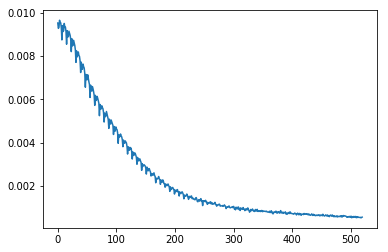

In [599]:
plt.figure()
plt.plot(loss_data['pos_loss'])
plt.show()

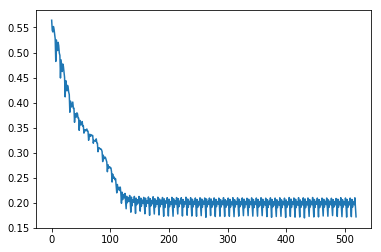

In [600]:
plt.figure()
plt.plot(loss_data['ori_loss'])
plt.show()

In [601]:
import scipy.signal as signal

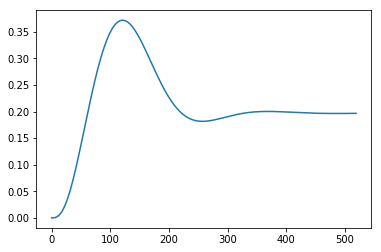

In [602]:
# sos = signal.butter(3, 0.03, 'low', output='sos')
sos = signal.butter(3, 0.01, 'low', output='sos')
filtered = signal.sosfilt(sos, loss_data['ori_loss'])

plt.figure()
plt.plot(filtered)
plt.show()